# Exploring the data

My impressions so far:

* The biggest challenge is dealing with the Breed, Color and Name variables
* Many of the variables are going to have interactions with one another, especially the AnimalType variable, therefore it may be useful to use a model that automatically considers feature interactions (ex. a Random Forest) over a model that requires us to manually create feature interactins (ex. Logistic Regression)
* Not a huge number of missing values in the training set, save for animal name, where not knowing the animal's name (or the animal not having a name) certainly tells us something useful...it may be worth imputing neutered and gender

Data cleaning / feature engineering overview:

* Split `SexuponOutcome` into separate neutered and gender features
* `AgeuponOutcome` is converted into a numeric feature
* `DateTime` is converted into a set of date-specific features (year, month, day of the week, etc.)
* The 1380 breeds are reduced into a smaller set of features
* The 300... colors are reduced into a smaller set of features

In [1]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sklearn

train = pd.read_csv('train.csv')

/home/jake/miniconda2/envs/shelter-animals/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Overview

See what the data look like.

In [2]:
print 'Number of training observations:', len(train.index)
train.head()

Number of training observations: 26729


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Missing values by column:

In [3]:
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

## Examining the dependent variable, `OutcomeType`

What happened to the animals?

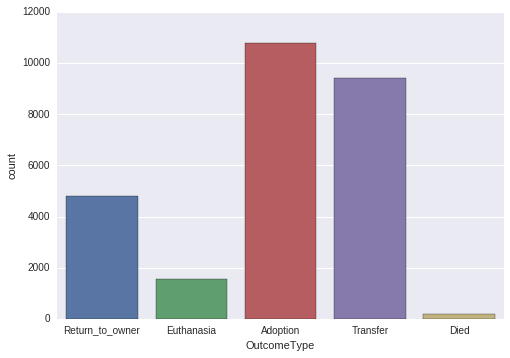

In [4]:
sns.countplot(x = "OutcomeType", data = train)

## Examining the independent variables

### `AnimalType`

Whether it's a cat or a dog.

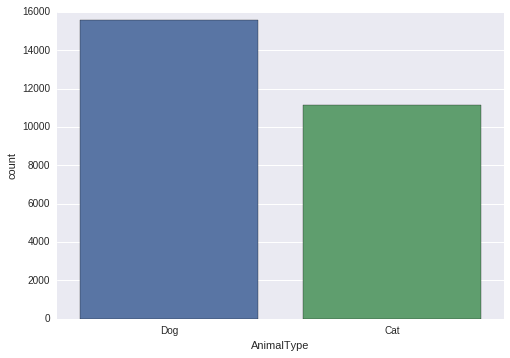

In [5]:
sns.countplot(x = "AnimalType", data = train)

`OutcomeType` by `AnimalType`

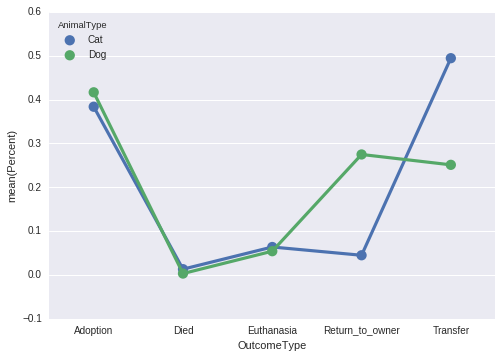

In [75]:
sns.pointplot(x = 'OutcomeType', y = 'Percent', hue = 'AnimalType', data = (train
    .groupby(['OutcomeType', 'AnimalType'])
    .size()
    .reset_index()
    .rename(columns = {0: 'Count'})
    .merge(
        (train
         .groupby(['AnimalType'])
         .size()
         .reset_index()
         .rename(columns = {0: 'Total'})
        ),
    how = 'inner', on = 'AnimalType')
    .assign(Percent = lambda x: x.Count / x.Total)
))

Visually, there looks to be a strong relationship between the outcome and what kind of animal there is - dogs are much more frequently returned to their owners, cats are more likely to die, etc.

### `SexuponOutcome`

This variable measures the sex of the animal as well as whether or not it is able to reproduce at the time of the outcome.

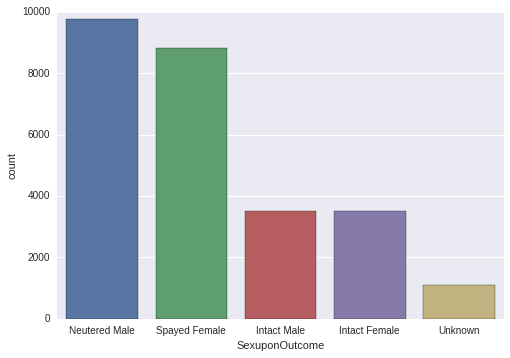

In [7]:
sns.countplot(x = "SexuponOutcome", data = train)

I'm thinking that these should be split into the following 2 variables instead of being in a single variable:

* Sex - Male / Female
* NeuteredSprayed - True / False

There is probably an interaction between these two variables, so some models (such as logistic regression) would need that interaction term left in, whereas other models (random forests) could discover these interactions.

In [8]:
def create_sex_variables(SexuponOutcome):
    results = []
    for row in SexuponOutcome:
        row = row.split(' ')
        if len(row) == 1:
            row = ['Unknown', 'Unknown']
        results.append(row)
    return zip(*[['Neutered', x[1]] if x[0] == 'Spayed' else x for x in results])

# 1 NA value, fill it in with 'Unknown'
NeuteredSprayed, Sex = create_sex_variables(list(train['SexuponOutcome'].fillna('Unknown')))
train = (train
         .assign(Neutered = NeuteredSprayed)
         .assign(Sex = Sex)
         .drop(['SexuponOutcome'], axis = 1))

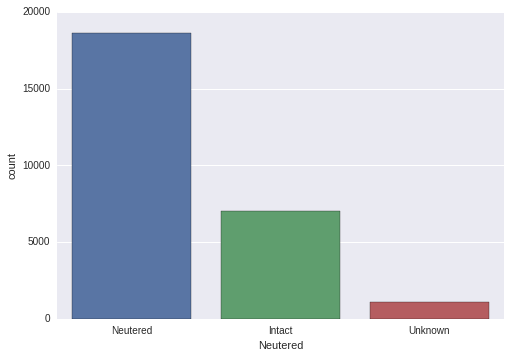

In [9]:
sns.countplot(x = "Neutered", data = train)

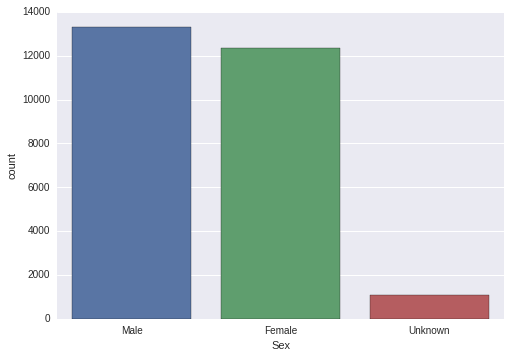

In [10]:
sns.countplot(x = "Sex", data = train)

### `AgeuponOutcome` 

Should be transformed into a numerical variable. There are 18 NAs - given how few, let's not worry too much about them and just impute the mean.

In [11]:
def create_age_in_years(ages):
    results = []
    units = {'days': 365.0, 'weeks': 52.0, 'months': 12.0}
    for age in ages:
        if age == 'NA':
            results.append('NA')
        else:
            duration, unit = age.split(' ')
            results.append(float(duration) / units.get(unit, 1.0))
    impute = np.mean([age for age in results if age != 'NA'])
    return [age if age != 'NA' else impute for age in results]

train = (train
         .assign(Age = create_age_in_years(list(train['AgeuponOutcome'].fillna('NA'))))
         .drop(['AgeuponOutcome'], axis = 1))

Look at the distribution of ages:

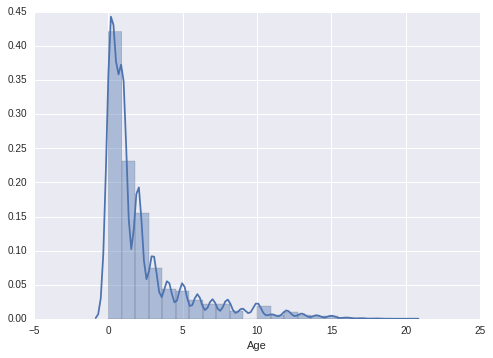

In [12]:
sns.distplot(train['Age'], bins = 22)

The right skew makes sense in the context of age. Let's quickly take a look at how age affects outcome:

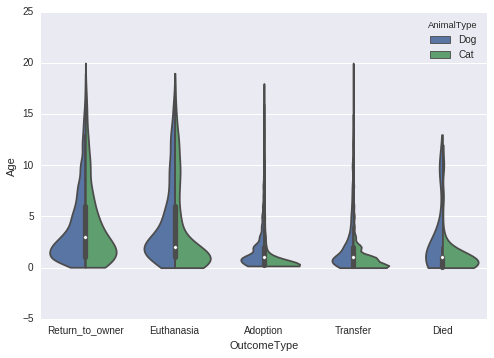

In [13]:
sns.violinplot(x = "OutcomeType", y = "Age", hue = "AnimalType", data = train, cut = 0, split = True)

Animals returned to their owners tend to be slightly older.

### `DateTime`

We want to split this into multiple variables:

* Year, month, day of the week, time (morning, afternoon, evening, night)

In [14]:
def time_of_day(hour):
    if hour > 4 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    else:
        return 'evening/night'
    
def day_of_the_week(DateTime):
    return datetime.datetime.strptime(DateTime, '%Y-%m-%d %H:%M:%S').weekday()

train = (train
         .assign(Year = train.DateTime.map(lambda x: x[:4]))
         .assign(Month = train.DateTime.map(lambda x: x[5:7]))
         .assign(Day = train.DateTime.map(lambda x: day_of_the_week(x)))
         .assign(TimeOfDay = train.DateTime.map(lambda x: time_of_day(int(x[11:13]))))
         .drop(['DateTime'], axis = 1)
        )

Year

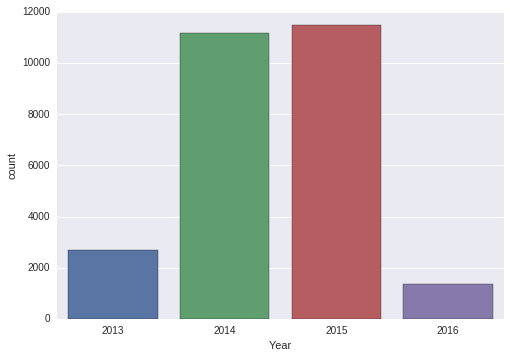

In [15]:
sns.countplot(x = "Year", data = train)

Month (Jan to Dec)

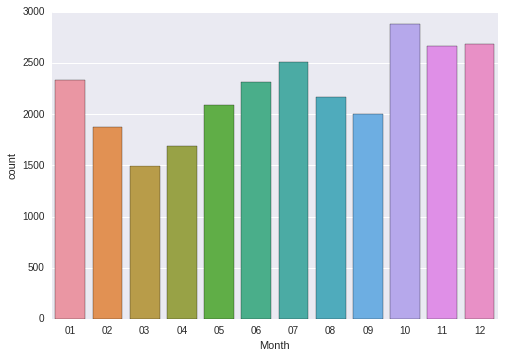

In [16]:
sns.countplot(x = "Month", data = train)

Day of the week (0 is Monday, 6 is Sunday)

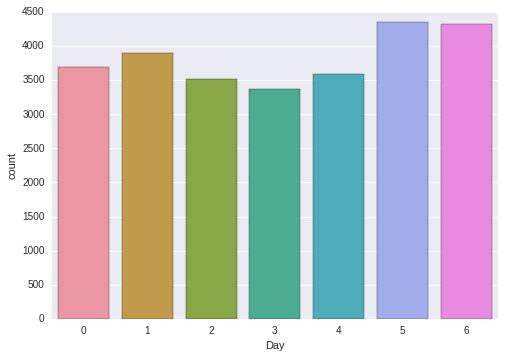

In [17]:
sns.countplot(x = "Day", data = train)

Time of the day

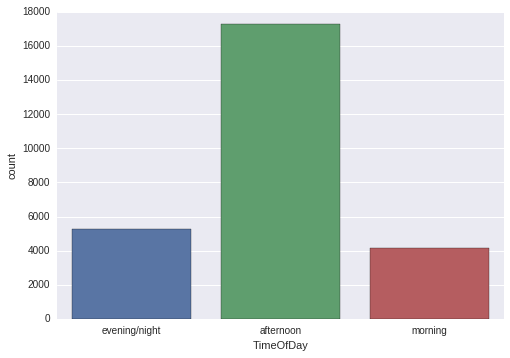

In [18]:
sns.countplot(x = "TimeOfDay", data = train)

Breed only makes sense in the context of the animal species, of `AnimalType`

In [59]:
print 'Total number of breeds:', len(train['Breed'].unique())
print 'Number of cat breeds:', len(train[train['AnimalType'] == 'Cat']['Breed'].unique())
print 'Number of dog breeds:', len(train[train['AnimalType'] == 'Dog']['Breed'].unique())

Total number of breeds: 1380
Number of cat breeds: 60
Number of dog breeds: 1320


Given the massive number of breeds (mostly for dogs) I am worried about overfitting w/ regard to breed. Here is the distribution of the (log) number of animals by breed for both animals. We can see there are a small number of breeds containing a large number of animals, and then many breeds with a very small number of animals.

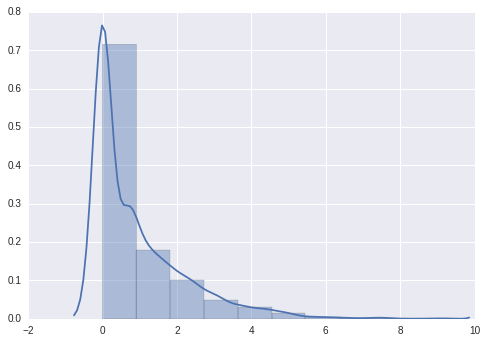

In [56]:
sns.distplot(np.log(train.groupby('Breed').size().values), bins = 10)

*Dog Breeds*

Let's look at the names of the top breeds to see if we can get any ideas around how to structure this feature.

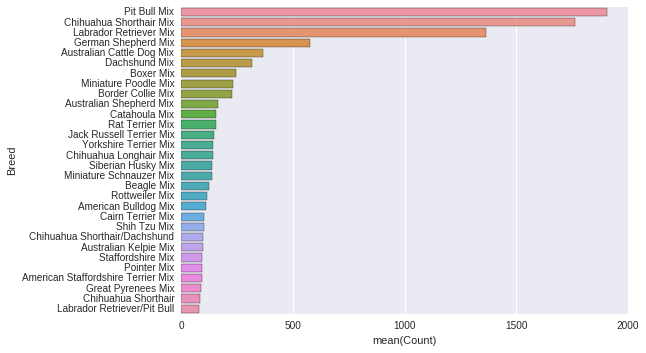

In [63]:
sns.barplot(x = "Count", y = "Breed", data = (
        train[train['AnimalType'] == 'Dog']
        .groupby(['Breed'])
        .size()
        .reset_index()
        .rename(columns = {0: 'Count'})
        .sort_values(['Count'], ascending = False)
        .head(n = 30)))

### `Color`

I'm guessing that color's affect on the outcome is sometimes dependent on the animal type, and sometimes not, as in some colors may be appreciated across enmails, while some may be animal specific. Given the likely interactions between variables I would consider a model that considers interactions (neural networks, decisions trees) vs. a model that doesn't take these interactions into account automatically (logistic regression, KNN).

In [22]:
print 'Number of colors:', len(train['Color'].unique())
train['Color'].unique()[:10]

Number of colors: 366


array(['Brown/White', 'Cream Tabby', 'Blue/White', 'Blue Cream', 'Tan',
       'Black/Tan', 'Blue Tabby', 'Brown Tabby', 'Red/White', 'White'], dtype=object)

Note that /'s separate cases where an animal is multiple colors, so let's see animal counts by color (this count will be higher than the number of training examples since animal's coats can contain multiple colors).

Number of distinct colors: 36


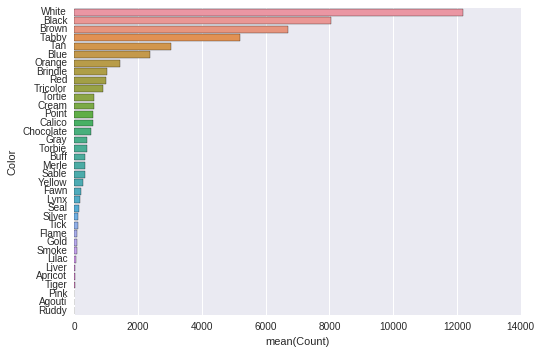

In [23]:
colors = {}
for color in list(train['Color']):
    color = re.split('\W+', color)
    for subcolor in color:
        try:
            colors[subcolor] += 1
        except:
            colors[subcolor] = 1
            
print 'Number of distinct colors:', len(colors)
sns.barplot(y = "Color", x = "Count", 
            data = (pd.DataFrame(colors.items(), columns=['Color', 'Count'])
                    .sort_values(['Count'], ascending = False)))

36 isn't a huge number of features. It probably makes sense split these into 36 binary features, where a training example may have 1's for multiple color features. Like many of these other variables, there are likely interactions between these features (ex. a difference between brown, gold, and gold/brown).

### `Name`

My intuition is that a name itself isn't that important in relation to animal outcome, though I see two areas where the name may matter:

* Whether or not the animal even has a name (or the shelters knows the name) - animals with no names may have been more poorly treated, which could affect the animal outcome, and
* How common the animal's name is

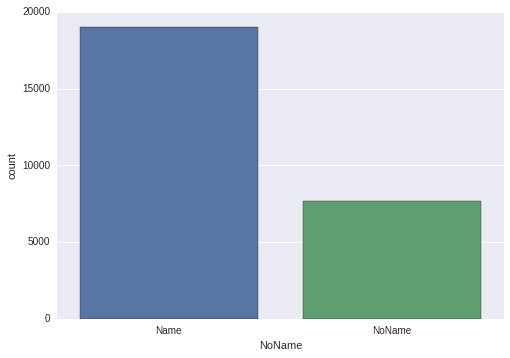

In [24]:
train['NoName'] = np.where(train['Name'].isnull(), 'NoName', 'Name')
sns.countplot(x = "NoName", data = train)

Most common names:

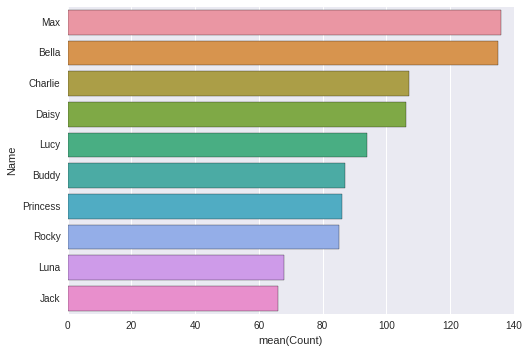

In [40]:
sns.barplot(x = "Count", y = "Name", data = (
        train[train['Name'].notnull()]
        .groupby(['Name'])
        .size()
        .reset_index()
        .rename(columns = {0: 'Count'})
        .sort_values(['Count'], ascending = False)
        .head(n = 10)))

Least common names

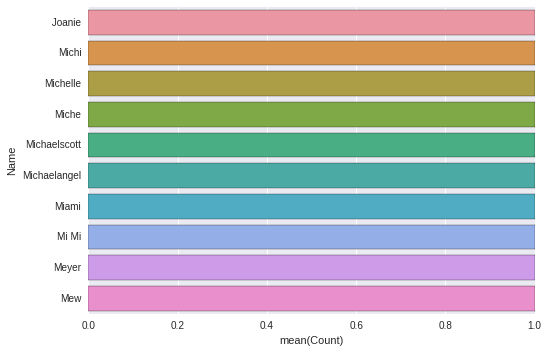

In [42]:
sns.barplot(x = "Count", y = "Name", data = (
        train[train['Name'].notnull()]
        .groupby(['Name'])
        .size()
        .reset_index()
        .rename(columns = {0: 'Count'})
        .sort_values(['Count'])
        .head(n = 10)))